# Начало тестовой работы. Подготовка данных.

In [1]:
! gdown 1YyDffwDgbLYRpePTLVLDoFYwTR44gS77
! gdown 1Id5mSLhiucUuJ9zPUdEbSPMm83oJdpld

Downloading...
From: https://drive.google.com/uc?id=1YyDffwDgbLYRpePTLVLDoFYwTR44gS77
To: /content/Точки.xlsx
100% 4.48k/4.48k [00:00<00:00, 9.54MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Id5mSLhiucUuJ9zPUdEbSPMm83oJdpld
To: /content/Объемы.csv
100% 7.53M/7.53M [00:00<00:00, 45.6MB/s]


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from xgboost import plot_importance

In [3]:
# Загрузка данных
with open('/content/Объемы.csv',  encoding="cp1251", errors='ignore') as source_file:
        df = pd.read_csv(source_file, delimiter=";", parse_dates=['s. Days fact'])
points = pd.read_excel('/content/Точки.xlsx')[1:]

# Для удобства работы удалю хештег перед номером точки
df['Точки'] = df['Точки'].apply(lambda x: x[1:]).astype(float)
points['Item Name'] = points['Item Name'].apply(lambda x: x[1:]).astype(float)

# Добавление в таблицу с продажами информации о круглосуточности и наличии автопокупки в точках из  points
df = df.merge(points[['Item Name', 'Круглосуточно?', 'Авто?', 'Дата открытия',
                      'Дата закрытия']], left_on='Точки', right_on='Item Name')

In [5]:
# Для удобства переименую столбцы, с использованием лдатиницы
df = df.rename(columns = {'s. Days fact' : 'date', 'Точки':'points',
                          'Тип реализации':'type', 'Блюда': 'dishies',
                          'Объёмы':'sales', 'Круглосуточно?' : 'day_night',
                          'Авто?':'auto', 'Дата открытия':'opened', 'Дата закрытия':'closed'}) 

In [6]:
# Для дальнешего использования в предсказании, заменим логические значения целочисленными
df['day_night'] = df['day_night'].apply(lambda x: 1 if x == True else 0)
df['auto'] = df['auto'].apply(lambda x: 1 if x == True else 0)

In [7]:
# Преобразование 'date' в правильный 'datetime' формат
# Извлечение дней, месяцев и годов из 'date'
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
# Извлечение дня недели для каждой даты
df['dayofweek'] = df['date'].dt.dayofweek

In [8]:
df.head(2)

,date,points,type,dishies,sales,Item Name,day_night,auto,opened,closed,day,month,year,dayofweek
0,2021-01-01,1.0,Где взял - там съел,Картошка без крахмала,317,1.0,1,0,06.08.2015,NaN,1,1,2021,4
1,2021-01-01,1.0,Бандеролью,Картошка без крахмала,254,1.0,1,0,06.08.2015,NaN,1,1,2021,4


In [9]:
# Здесь, убедимся, что в интересующих столбцах нет пропущенных значений. Это очень хорошо
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160272 entries, 0 to 160271
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       160272 non-null  datetime64[ns]
 1   points     160272 non-null  float64       
 2   type       160272 non-null  object        
 3   dishies    160272 non-null  object        
 4   sales      160272 non-null  int64         
 5   Item Name  160272 non-null  float64       
 6   day_night  160272 non-null  int64         
 7   auto       160272 non-null  int64         
 8   opened     160272 non-null  object        
 9   closed     15264 non-null   object        
 10  day        160272 non-null  int64         
 11  month      160272 non-null  int64         
 12  year       160272 non-null  int64         
 13  dayofweek  160272 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(7), object(4)
memory usage: 18.3+ MB


# Визуализация признаков. Поиск закономерностей.

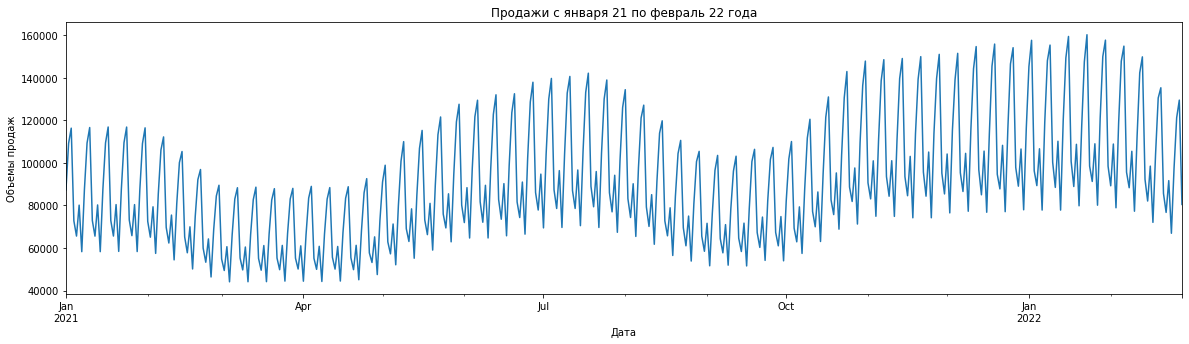

In [ ]:
sales = df.groupby('date')['sales'].sum()
plt.figure(figsize=(20,5))
sales.plot()
plt.title("Продажи с января 21 по февраль 22 года")
plt.xlabel('Дата')
plt.ylabel('Объемы продаж') 
plt.show()

На данном графике с объемами продаж наблюдается сезонный тренд и увеличение объемов продаж со временем.

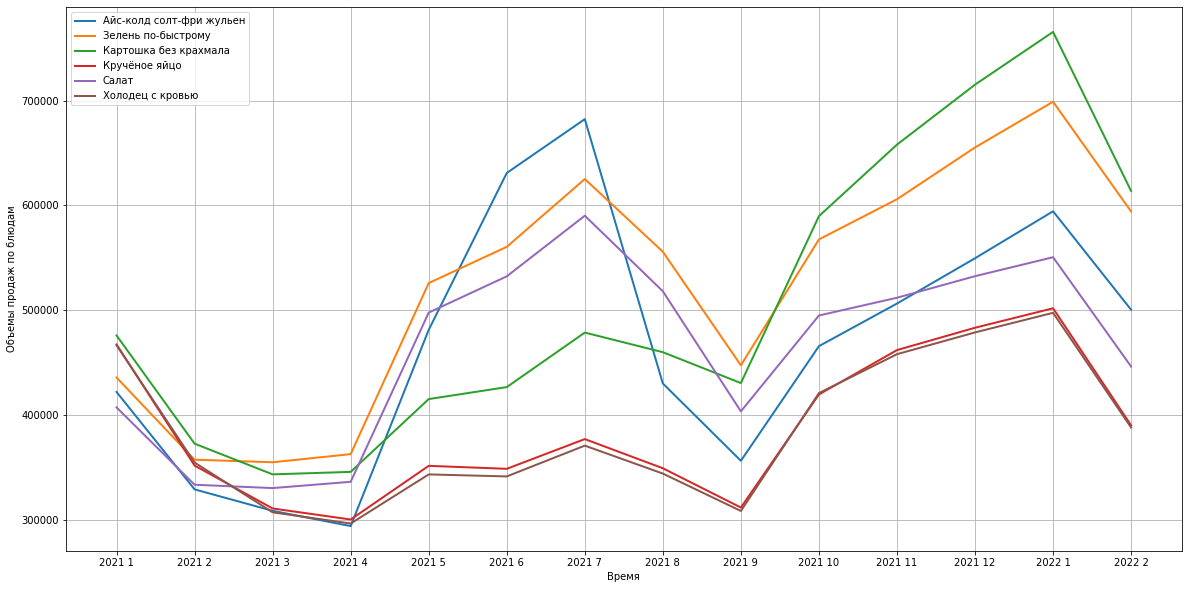

In [ ]:
sales_dishies = df.groupby(['year', 'month', 'dishies'])['sales'].sum().reset_index()
sales_dishies['date'] = sales_dishies.apply(lambda x: str(x['year']) + ' ' + str(x['month']), axis = 1)

plt.figure(figsize=(20, 10))  
ax = plt.axes()
for dish in sales_dishies.dishies.unique():
  tmp = sales_dishies[sales_dishies['dishies'] == dish]
  plt.plot(sales_dishies['date'].unique(), tmp['sales'], label=dish, linewidth=2)
  plt.legend()

plt.xlabel('Время')                    
plt.ylabel('Объемы продаж по блюдам') 
plt.grid()   
plt.show()     

В зимние месяца популярна картошка без крахмала. В летние Айс-колд жульен. Что не удивительно. Самыми "непопулярными" блюдами на протяжении всего времени являются Холодец с кровью и крученое яйцо.

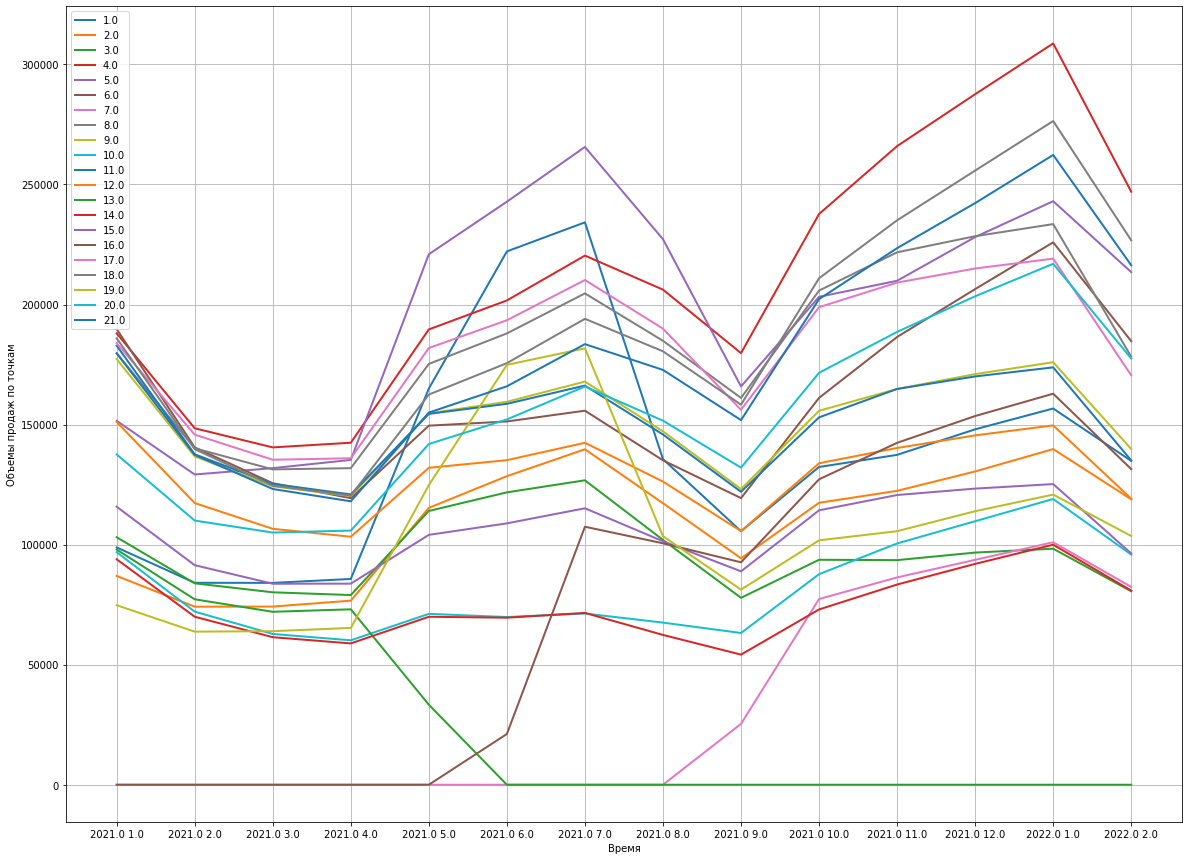

In [ ]:
sales_points = df.groupby(['year', 'month', 'points'])['sales'].sum().reset_index()
sales_points['date'] = sales_points.apply(lambda x: str(x['year']) + ' ' + str(x['month']), axis = 1)

plt.figure(figsize=(20, 15))  
ax = plt.axes()
for point in sales_points.points.unique():
  tmp = sales_points[sales_points['points'] == point]
  plt.plot(sales_points['date'].unique(), tmp['sales'], label=point, linewidth=2)
  plt.legend()

plt.xlabel('Время')                    
plt.ylabel('Объемы продаж по точкам') 
plt.grid()   
plt.show()     

Из графика продаж по точкам мы видим, что в зимние периоды наибольших объемов продаж добилась 4я точка, а, в летний период, по объемам лидирует 5я точка.

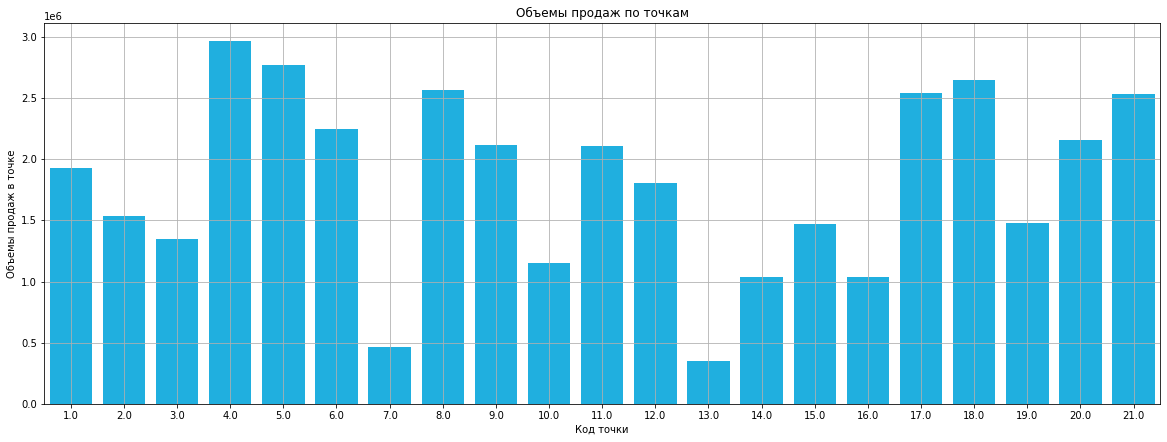

In [ ]:
best_points = sales_points.groupby('points')['sales'].agg(['count', 'sum', 'mean']).sort_values(by='sum', ascending=False).reset_index()

plt.figure(figsize=(20, 7))
sns.barplot(data=best_points, x="points", y="sum", color = 'deepskyblue')
plt.title('Объемы продаж по точкам')
plt.xlabel('Код точки')                    
plt.ylabel('Объемы продаж в точке') 
plt.grid()
plt.show()

В целом, в лидерах по по объемам у нас 4, 5, 18, 8 и 21 точки.

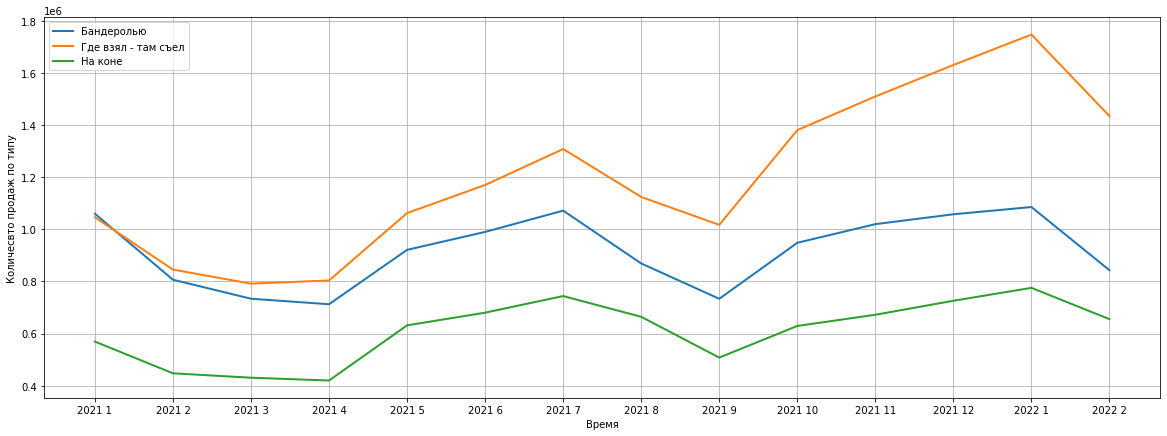

In [ ]:
sales_types = df.groupby(['year', 'month', 'type'])['sales'].sum().reset_index()
sales_types['date'] = sales_types.apply(lambda x: str(x['year']) + ' ' + str(x['month']), axis = 1)

plt.figure(figsize=(20, 7))  
ax = plt.axes()
for t_u in sales_types['type'].unique():
  tmp = sales_types[sales_types['type'] == t_u]
  plt.plot(sales_types['date'].unique(), tmp['sales'], label=t_u, linewidth=2)
  plt.legend()
plt.xlabel('Время')                    
plt.ylabel('Количесвто продаж по типу') 
plt.grid()   
plt.show()     

На данном графике видно, что тип покупки "Где взял - там и съел" в январе 2021 вырвался вперед по популярности и, с течением времени, становится все более актуальным для покупателей. Популярность остальных двух типов покупок остается без изменений.

In [ ]:
# Здесь написана функция для наблюдения сезонных трендов
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=30,
            figsize=(20,5)):    
   rolling_mean = ts.rolling(window=window).mean()    
   rolling_std = ts.rolling(window=window).std()
   plt.figure(figsize=figsize)    
   plt.title(ts.name)    
   plt.plot(ts[window:], label='Текущие продажи', color="black")    
   if plot_ma:        
      plt.plot(rolling_mean, 'g', label='MA'+str(window),
               color="red")    
   if plot_intervals:
    lower_bound = rolling_mean - (1.96 * rolling_std)
    upper_bound = rolling_mean + (1.96 * rolling_std)
   plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                    color='lightskyblue', alpha=0.4)
   plt.legend(loc='best')
   plt.grid()
   plt.show()

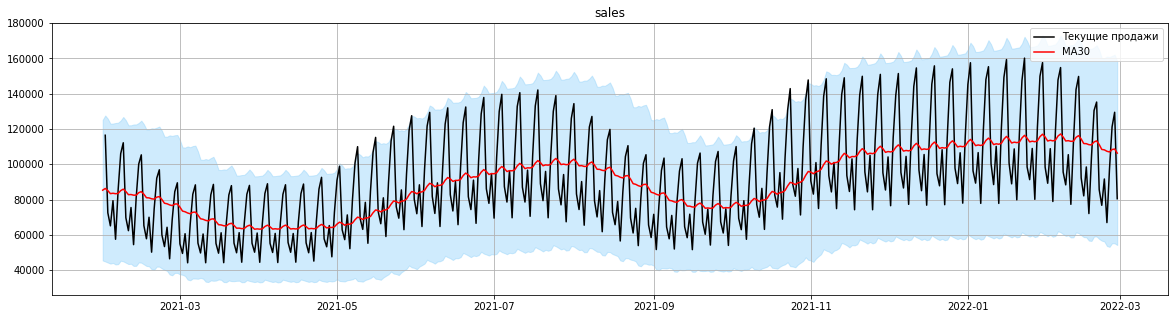

In [ ]:
plot_ts(sales, window=30)

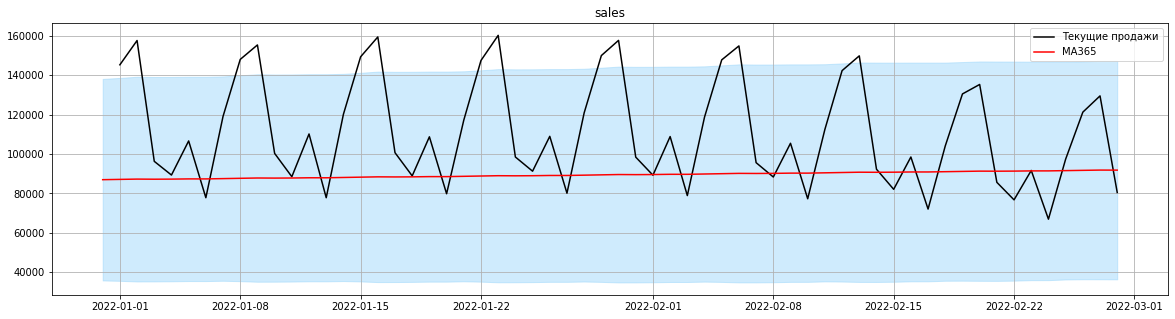

In [ ]:
plot_ts(sales, window=365)

В целом, объемы продаж компании растут. При этом, наблюдается сезонный тренд. Самые высокие продажи летом, затем осенью они падают, снова вырастают зимой и становяться меньше весной.

# Обработка данных для прогнозирования

In [ ]:
# Преобразование типа реализации, блюда и года(чтобы получить потом порядковый номер дня) в нормализованный вектор [0-max]
type_le = preprocessing.LabelEncoder()
type_le.fit(df['type'].unique())
df['type_encoded'] = type_le.transform(df['type'])

dish_le = preprocessing.LabelEncoder()
dish_le.fit(df['dishies'].unique())
df['dish_encoded'] = dish_le.transform(df['dishies'])

year_le = preprocessing.LabelEncoder()
year_le.fit(df['year'].unique())
df['year_encoded'] = year_le.transform(df['year'])

In [ ]:
# Так как 7 и 13 точки открылись лишь в 2021 году, некоторые сведения о продажах являются нулевыми и будет мешаеют обучению модели, аналогично с 16 точкой, закрывшейся в 2021 году
# Чтобы изюавиться от вышеуказанных значений, отфильтруем данные
df_7 = df[df['points'] == 7]
df_16 = df[df['points'] == 16]
df_13 = df[df['points'] == 13]
df = df.query('points not in  (7, 13, 16)')
df_7 = df_7[df_7['date'] > '2021-09-17']
df_16 = df_16[df_16['date'] > '2021-06-24']
df_13 = df_13[df_13['date'] < '2021-05-13']
df = pd.concat([df, df_7, df_16, df_13])

In [ ]:
# Генерация порядкого номера дня для каждой даты
df['day_block_num'] = df.apply(lambda x: int(x['date'].strftime('%j')), axis=1)
df['day_block_num'] = df['day_block_num'] + 365 * df['year_encoded']
df['month_block_num'] = df['month'] + 12 * df['year_encoded'] - 1

# Генерация нормализованного порядкого номера дня для каждой даты
day_block_num_le = preprocessing.LabelEncoder()
day_block_num_le.fit(df['day_block_num'].unique())
df['day_block_num_encoded'] = day_block_num_le.transform(df['day_block_num'])

# Сортировка данных по нормализованному порядковому номеру дня
df = df.sort_values(by='day_block_num_encoded', ascending=True)
df['points'] = df['points'].astype(np.int64)

df.head(2)

,date,points,type,dishies,sales,Item Name,day_night,auto,opened,closed,day,month,year,dayofweek,type_encoded,dish_encoded,year_encoded,day_block_num,month_block_num,day_block_num_encoded
0,2021-01-01,1,Где взял - там съел,Картошка без крахмала,317,1.0,1,0,06.08.2015,NaN,1,1,2021,4,1,2,0,1,0,0
15277,2021-01-01,3,Бандеролью,Айс-колд солт-фри жульен,207,3.0,1,0,16.04.2004,10.03.2022,1,1,2021,4,0,0,0,1,0,0


In [ ]:
# Оставим в таблице лишь необходимые для предсказания столбцы
df = df[['points', 'type_encoded', 'dish_encoded', 'sales', 'month', 'dayofweek',  'year_encoded',
       'month_block_num', 'day_block_num_encoded', 'day_night', 'auto']]

# Подготовка и обучение модели

In [ ]:
# Создадим тренировочные и тестовые выборки, выделим из них целевые переменные
X_train, X_test, y_train, y_test = train_test_split(df.drop('sales', axis=1), df['sales'], test_size=0.25, random_state=42)

In [ ]:
# Посмотрим на размеры тренировочной и тестовой выборок
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(110389, 10) (110389,)
(36797, 10) (36797,)


In [ ]:
# Тут я решил написать функцию, преобразующую в 0 предсказания продаж меньше 10
def scale(x):
  return round(x) if x > 10 else 0 

In [ ]:
# Так как я подбирал параметры максимальной глубины и количесвтва деревьев, для удобной работы была создана функция, в которой обучалась модель
# функиция возвращает ошибку и саму модель 
def model_fit(max_depth=15, n_estimators=1000):
  model = XGBRegressor(
          max_depth=max_depth,
          n_estimators=n_estimators,
          min_child_weight=300, 
          colsample_bytree=0.8, 
          subsample=0.8, 
          eta=0.5,    
          seed=42,
          learning_rate=0.02,
          n_estimators=10,
          objective="binary:logistic",
          nthread=3,
          tree_method="gpu_hist")

  model.fit(
          X_train, 
          y_train, 
          eval_metric="rmse", 
          eval_set=[(X_train, y_train), (X_test, y_test)], 
          verbose=False, 
          early_stopping_rounds = 50)

  Y_valid_predicted = model.predict(X_test)
  Y_valid_predicted = list(map(scale, Y_valid_predicted))
  mean_absolute_error(y_test, Y_valid_predicted) / y_test.mean()

  return mean_absolute_error(y_test, Y_valid_predicted) / y_test.mean(),  model

SyntaxError: ignored

В процессе подбора параметров, использу GridSearchCV, я увидел, что, чем выше максимальная глубина и количество деревьев, тем лучше работает модель. В дальнейшем я решил ограничиться глубиной в 11 и количеством деревьев 10000. Это давало минимальный процент ошибки равный 2, вычесленный по формуле: отношение средней асолютной ошибки к среднему объему в тестовых данных. При этом, модель тренировалась окола часа. но это не старшно :)

In [ ]:
err, model = model_fit(11, 100)

In [ ]:
print('Ошибка составляет', round(err * 100, 2), "процента!")

Будем верить, что модель настроена и готова к работе. Однако, для формирования данных, по которым будет проводиться прогноз, нам нужно подготовить датасет с данными на март 2022.

In [ ]:
featers = ['Точка', 'Тип реализации', 'Блюдо', 'Месяц_кодированный', 'День недели',
       'Год', 'Месяц', 'Порядковый номер дня', 'Крглосуточно?',
       'Авто?']
imp = pd.DataFrame(data=[featers, model.feature_importances_]).T.sort_values(by=1, ascending=False).iloc[:7]

plt.figure(figsize=(12, 7), dpi= 80)
plt.bar(imp[0], imp[1])
plt.xlabel('Признак')                    
plt.ylabel('Уровень значимости') 
plt.xticks(rotation=45)
plt.show()

На данном графике отражено влияние каждого из признаков на объем продаж. Комментировать тут особо нечего, все наглядно видно.

# Создание датасета для предсказаний продаж в марте 2022.


In [ ]:
# Создам списки с уникальными значениями точек, типов продаж, блюд и уникальных меток дней
points = df.points.unique()
types = df.type_encoded.unique()
dishies = df.dish_encoded.unique()
days = list(range(424, 424 + 31))

# 'матрешка' из циклов создаст все возможные уникальные комбинации из перебираемых списков
# объединив их в общий список, мы получим датасет для дальнейшего предсказания в марте 22
tmp = []
for day in days:
  for dish in dishies:
    for type_un in types:
      for point in points:
        x = pd.Series([point, type_un, dish, day])
        tmp.append(x)   
df_pred = pd.DataFrame(data=tmp)
df_pred = df_pred.rename(columns={0:'points', 1:'type_encoded', 2:'dish_encoded', 3:'day_block_num_encoded'})

In [ ]:
# Установлю вручную недостающие параметры модели
df_pred['month'] = 3
df_pred['dayofweek'] = (df_pred['day_block_num_encoded'] + 4) % 7
df_pred['year_encoded'] = 1
df_pred['month_block_num'] = 14
df_pred['points'] = df_pred['points'].astype(float)

# Подгоню форматы данных под те, на которых обучалась модель
points = pd.read_excel('/content/Точки.xlsx')[1:]
points['Item Name'] = points['Item Name'].apply(lambda x: x[1:]).astype(float)
df_pred = df_pred.merge(points[['Item Name', 'Круглосуточно?', 'Авто?']], left_on='points', right_on='Item Name')
df_pred = df_pred.rename(columns = {'Круглосуточно?' : 'day_night', 'Авто?':'auto'}) 
df_pred['day_night'] = df_pred['day_night'].apply(lambda x: 1 if x == True else 0)
df_pred['auto'] = df_pred['auto'].apply(lambda x: 1 if x == True else 0)
df_pred = df_pred.drop('Item Name', axis= 1)

# Ну и порядок следования столбцов тоже надо поменять
df_pred = df_pred.reindex(columns=['points', 'type_encoded', 'dish_encoded', 'month', 'dayofweek',
       'year_encoded', 'month_block_num', 'day_block_num_encoded', 'day_night',
       'auto'])

In [ ]:
df_pred['points'] = df_pred['points'].astype(np.int64)
df_pred['type_encoded'] = df_pred['type_encoded'].astype(np.int64)
df_pred['dish_encoded'] = df_pred['dish_encoded'].astype(np.int64)
df_pred['dayofweek'] = df_pred['dayofweek'].astype(np.int64)
df_pred['month_block_num'] = df_pred['month_block_num'].astype(np.int64)
df_pred['day_block_num_encoded'] = df_pred['day_block_num_encoded'].astype(np.int64)

# И вот наконец то ради чего мы тут собрались. ПРОГНОЗИРОВАНИЕ!

In [ ]:
predict = list(map(scale, model.predict(df_pred)))
df_pred['sales'] = predict
df_pred.head(2)

In [ ]:
# 13 точка уже давно закрыта, а вот треться закрылась 10 числа, изменим предсказанные им значения на 0
df_pred.loc[df_pred['points'] == 13, 'sales'] = 0
df_pred.loc[(df_pred['points'] == 3) & (df_pred['day_block_num_encoded'] > 434), 'sales'] = 0

In [ ]:
print(f'Средний обем продаж в марте 2022: {round(df_pred.sales.mean(), 2)} \
\nСредний объем продаж в марте 2021: {round(df[df.month == 3].sales.mean(), 2)}\
\nСредний объем продаж за весь период: {round(df.sales.mean(), 2)}')

In [ ]:
df_pred['day_block_num_encoded'] = df_pred['day_block_num_encoded'] % 423
sales = df_pred.groupby('day_block_num_encoded')['sales'].sum().rename('sales')
plt.figure(figsize=(20,5))
sales.plot()
plt.title("Продажи за март 2022")
plt.xlabel('Дата')
plt.show()

Визуализировав предсказания продаж модели по дням, можно сделать вывод, что они, как минимум, соответсвуют дневному тренду и не противоречат логике. Явно выражены 4 пиковых знаячения по субботам и воскременьям.

In [ ]:
df_pred['day_block_num_encoded'] = df_pred['day_block_num_encoded'] + 423

In [ ]:
# Объединим имевшиеся и спрогнозированные значения объемов и оценим как они "вписываются" в общий график объемов продаж
df = pd.concat([df, df_pred])
sales = df.groupby('day_block_num_encoded')['sales'].sum().rename('sales')
plt.figure(figsize=(20,7))
sales.plot()
plt.title("Продажи за имеющийся период и март 2022")
plt.xlabel('Дата')
plt.show()

In [ ]:
plot_ts(sales, window=30)

Судя по графикам, прогнозы, как минимум, похожи на правду, наблюдается тенденция небольшого уменьшения продаж, как и годом ранее. Сезонные и дневные тенденции соответствуют имеющимся данным.

# Формирование csv таблицы для отчета

Здесь я проведу ряд махинаций с данными, которые, думаю, можно не комментировать. В итогде, будет получен Exel файл с данными, соответсвующими формату, указанному в задачии.

In [ ]:
df_pred['s. Days fact'] = df_pred['day_block_num_encoded'].apply(lambda x: str(int(x % 423)) + ' Mar 21')
df_pred['Точки'] = df_pred.points.apply(lambda x: '#' + str(int(x)))
df_pred['type_encoded'] = type_le.inverse_transform(df_pred['type_encoded'])
df_pred['dish_encoded'] = dish_le.inverse_transform(df_pred['dish_encoded'])

df_pred = df_pred.rename(columns={'sales': 'Прогнозные объёмы', 'type_encoded': 'Тип реализации', 'dish_encoded': 'Блюда'})
df_pred = df_pred[['s. Days fact', 'Точки', 'Тип реализации', 'Блюда', 'Прогнозные объёмы', 'points']]
df_pred['Datetime'] = pd.to_datetime(df_pred['s. Days fact'])
t = {'Где взял - там съел' : 1, 'Бандеролью' : 2, 'На коне' : 3}
d = {'Картошка без крахмала' : 1, 'Айс-колд солт-фри жульен' : 5,
       'Холодец с кровью' : 6, 'Салат' : 4, 'Зелень по-быстрому' : 3, 'Кручёное яйцо' : 2}
       
df_pred['type_encode'] = df_pred['Тип реализации'].apply(lambda x: t[x])
df_pred['d_encode'] = df_pred['Блюда'].apply(lambda x: d[x])
df_total = df_pred.sort_values(['Datetime', 'd_encode', 'type_encode', 'points'],
                               ascending=[True, True, True, True]).drop(['Datetime', 'type_encode', 'd_encode', 'points'], axis=1).reset_index().drop('index', axis=1)
df_total['Кандидаты'] = 'Кузичев Вячеслав'
df_total = df_total.set_index('s. Days fact')
df_total

In [ ]:
df_total.to_csv('Прогноз.csv', encoding="utf-8-sig", errors='ignore', sep=';')